## Imports

In [1]:
import os
import math
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from read_data import *
from aux_functions import *

classes_dict = {
    'by_country' : 4,
    'by_style' : 7,
    'by_product' : 2
}

## Set the classification problem

In [2]:
problem_type = 'by_style'

## Set saving / restoring

In [3]:
restoring_mode = False
saving_mode = False

restoring_name = 'first_model.ckpt'
saving_name = 'by_notebook.ckpt'

restoring_path = os.path.join('models', problem_type, restoring_name)
saving_path = os.path.join('models', problem_type, saving_name)

## Adjust Hyperparameters

In [4]:
EPOCHS = 1e6
BATCH_SIZE = 32
VALIDATION_BATCH = 32

IMG_SIZE = 150
CLASSES = classes_dict[problem_type]

## Neural Network functions

### Convolution Layers

In [5]:
def conv_layer(X, filters, filter_size, name, activation=None):
    """Create a new convolution layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()
    
        # create the parameter structures         
        W = tf.get_variable(initializer=init, 
                            shape=(filter_size[0], filter_size[1],
                                   in_channels, filters),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")
        
        # perform convolution and add bias
        conv = tf.nn.conv2d(X, W, strides=(1, 1, 1, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)
        
        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z

        
def pooling_layer(X, kernel_size):
    """Perform max pooling"""
    
    return tf.nn.max_pool(X,
                          ksize=(1, kernel_size[0], kernel_size[1], 1),
                          strides=(1, kernel_size[0], kernel_size[1], 1),
                          padding="VALID")

### Dense Layers

In [6]:
def dense_layer(X, n_neurons, name, activation=None):
    """Create a new fully connected layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        n_inputs = int(X.get_shape()[1])
        init = tf.contrib.layers.xavier_initializer()
        
        # create the parameter structures     
        W = tf.get_variable(initializer=init,
                            shape=(n_inputs, n_neurons),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(n_neurons),
                            name="biases")
        z = tf.matmul(X, W) + b
        
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

## Build the model and deploy it on a device

In [7]:
with tf.device('/cpu:0'):
    
    #==================[ READ AND PROCESS THE INPUT ]==================#
    
    # decide the dataset input type
    is_training = tf.placeholder(tf.bool, name="is_training")
        
    # load training data from input queues     
    images_trn, labels_trn = inputs(problem_type, BATCH_SIZE, EPOCHS)
    
    # load validation data from feed dictionary
    images_val = tf.placeholder(tf.uint8, shape=[VALIDATION_BATCH, IMG_SIZE, IMG_SIZE, 3])
    labels_val = tf.placeholder(tf.int32, shape=[VALIDATION_BATCH,])
    
    # choose the input
    images, labels = tf.cond(is_training, lambda: (images_trn, labels_trn),
                                          lambda: (images_val, labels_val))

    # normalize the images     
    images = (tf.cast(images, tf.float32) / 255.0)
    # correct the labels     
    labels = labels - 1

In [8]:
with tf.device('/gpu:0'):

    #==================[ CONVOLUTIONAL LAYERS ]==================#
    
    images_conv_11 = conv_layer(images, 16, (5, 5), "conv_11", "relu")
    images_conv_12 = conv_layer(images_conv_11, 16, (5, 5), "conv_12", "relu")
    images_pool_1  = pooling_layer(images_conv_12, (3, 3))
    
    images_conv_21 = conv_layer(images_pool_1, 32, (3, 3), "conv_21", "relu")
    images_conv_22 = conv_layer(images_conv_21, 32, (3, 3), "conv_22", "relu")
    images_pool_2  = pooling_layer(images_conv_22, (3, 3))
        
    #==================[     DENSE LAYERS     ]==================#
    
    images_flatten = tf.contrib.layers.flatten(images_pool_2)
    images_dense_1 = dense_layer(images_flatten, 128, "dense_1", "relu")
    images_dense_2 = dense_layer(images_dense_1, 128, "dense_2", "relu")
    
    #==================[     OUTPUT LAYER     ]==================#
    
    logits = dense_layer(images_dense_2, CLASSES, "logits")
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
    #==================[     OPTIMIZATION     ]==================#
    
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    training_op = optimizer.minimize(loss)
    
    #==================[      EVALUATION      ]==================#
    
    _, accuracy = tf.metrics.accuracy(labels=labels,
                                      predictions=tf.argmax(logits, -1))
    

Instructions for updating:
Use the retry module or similar alternatives.


## Create the session and start the threads for input queues

In [9]:
# create the session saver
saver = tf.train.Saver()

# create a session for running operations in the graph.
sess = tf.Session()

# create the variable initializers
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# initialize the variables
sess.run(init_op)

if restoring_mode:
    # previously saved model is restored
    saver.restore(sess, restoring_path)
    
# start input enqueue threads.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

## Collect data for Tensorboard

In [10]:
# clear tensorboard old data
try:
    shutil.rmtree(os.path.join('tensorboard', problem_type))
except FileNotFoundError:
    pass

with tf.device('/cpu:0'):
    
    summary_conv_12 = tf.summary.image('conv_12', images_conv_12[:,:,:,:3])
    summary_conv_22 = tf.summary.image('conv_22', images_conv_22[:,:,:,:3])
    
    train_loss = tf.summary.scalar('training_loss', loss)
    val_loss = tf.summary.scalar('validation_loss', loss)
    train_acc = tf.summary.scalar('training_accuracy', accuracy)
    val_acc = tf.summary.scalar('validation_accuracy', accuracy)

    convs_merged = tf.summary.merge([summary_conv_12, summary_conv_22])
    train_merged = tf.summary.merge([train_loss, train_acc])
    val_merged = tf.summary.merge([val_loss, val_acc])
    
    summary_writer = tf.summary.FileWriter(
        os.path.join('tensorboard', problem_type), sess.graph)

## Load validation data

In [11]:
# load validation data
images_validation = np.load(os.path.join('data_' + problem_type, 'testing_data.dat'))
labels_validation = np.load(os.path.join('data_' + problem_type, 'testing_labels.dat'))

## Training loop


Step   100 : Training >> loss = 1.541 accuracy = 26.30%  ||  Testing >> loss = 4.651 accuracy = 35.37%
Step   200 : Training >> loss = 0.794 accuracy = 42.53%  ||  Testing >> loss = 8.440 accuracy = 47.31%
Step   300 : Training >> loss = 0.429 accuracy = 52.18%  ||  Testing >> loss = 12.178 accuracy = 55.43%
Step   400 : Training >> loss = 0.344 accuracy = 58.08%  ||  Testing >> loss = 10.698 accuracy = 60.12%
Step   500 : Training >> loss = 0.217 accuracy = 62.27%  ||  Testing >> loss = 13.495 accuracy = 63.72%

           |   Gzhel   | Khokhloma | Gorodets  | Wycinanki |   Wzory   |   Iznik   | Neglyubka 
   Gzhel   |     0     |     7     |    95     |    16     |    20     |     0     |     6     
 Khokhloma |    122    |     0     |     0     |    13     |     8     |     0     |    17     
 Gorodets  |    106    |     0     |     9     |     0     |     9     |     0     |    28     
 Wycinanki |     4     |     0     |     1     |    26     |     9     |     0     |    48     


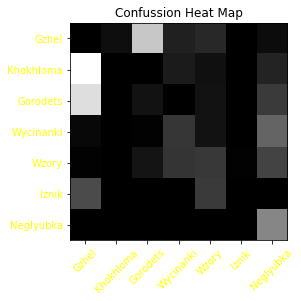


Step   600 : Training >> loss = 0.164 accuracy = 65.39%  ||  Testing >> loss = 14.050 accuracy = 66.36%
Step   700 : Training >> loss = 0.133 accuracy = 67.56%  ||  Testing >> loss = 16.817 accuracy = 68.37%
Step   800 : Training >> loss = 0.056 accuracy = 69.50%  ||  Testing >> loss = 20.113 accuracy = 70.25%
Step   900 : Training >> loss = 0.136 accuracy = 71.10%  ||  Testing >> loss = 15.301 accuracy = 71.41%

In [ ]:
try:
    step = 0
    MILESTONE = 100
    CONFUSSION_MILESTONE = 5 * MILESTONE
    
    min_val_loss = math.inf
    max_val_acc = -math.inf
    
    acc_sum = 0
    loss_sum = 0
    samples_count = 0
    
    # feed data until the epoch limit is reached     
    while not coord.should_stop():

        step += 1
        
        _, loss_value, acc_value, summary, img_sum = sess.run(
                [training_op, loss, accuracy, train_merged, convs_merged], feed_dict={
            is_training : True,
            images_val : images_validation[:VALIDATION_BATCH],
            labels_val : labels_validation[:VALIDATION_BATCH]
        })
        
        # save stats to log         
        summary_writer.add_summary(summary, step)
        summary_writer.add_summary(img_sum, step)
        
        acc_sum += acc_value
        loss_sum += loss_value
        samples_count += 1
                        
        if step % MILESTONE == 0:
            
            #===================[ TRAINING SCORE ]===================#
            
            training_acc = acc_sum / samples_count
            training_loss = loss_sum / samples_count
                
            print("\nStep {0:5d} : Training >> loss = {1:.3f} accuracy = {2:5.2f}%" \
                  .format(step, training_loss, 100 * training_acc), flush=True, end="")
            
            acc_sum = 0
            loss_sum = 0
            samples_count = 0  
        
            #===================[ TESTING SCORE ]===================#
            
            val_acc_sum = 0
            val_loss_sum = 0
            val_samples_count = 0  
            confussion_matrix = np.zeros((CLASSES, CLASSES), dtype=np.int32)
            
            for i in range(VALIDATION_BATCH, len(labels_validation), VALIDATION_BATCH):
                
                loss_value, acc_value, true, pred, summary = sess.run(
                    [loss, accuracy, labels, logits, val_merged], feed_dict={
                    is_training : False,
                    images_val : images_validation[(i - VALIDATION_BATCH):i],
                    labels_val : labels_validation[(i - VALIDATION_BATCH):i]
                })
                
                val_acc_sum += acc_value
                val_loss_sum += loss_value
                val_samples_count += 1
                for i in range(len(true)):
                    confussion_matrix[true[i], np.argmax(pred[i])] += 1
                                
            # save stats to log         
            summary_writer.add_summary(summary, step)
                
            validation_acc = val_acc_sum / val_samples_count
            validation_loss = val_loss_sum / val_samples_count
            
            print("  ||  Testing >> loss = {1:.3f} accuracy = {2:5.2f}%" \
                  .format(step, validation_loss, 100 * validation_acc), flush=True, end="")
                        
            # display confussion matrix             
            if step % CONFUSSION_MILESTONE == 0:
                display_confussion_matrix(confussion_matrix, problem_type)
                
            saving_condition = (validation_loss < min_val_loss)

            # save the model for later use         
            if saving_mode and saving_condition:
                saver.save(sess, saving_path)
                
            min_val_loss = min(min_val_loss, validation_loss)
            max_val_acc  = max(max_val_acc,  validation_acc)
        
        
except tf.errors.OutOfRangeError:
    
    print('\nDone training -- epoch limit reached\n')
    
finally:
    
    # when done, ask the threads to stop
    coord.request_stop()

    # wait for threads to finish
    coord.join(threads)
    sess.close()